# Configuración de la radio definida por Software

In [32]:
#---------------------------------------------------------------------------------
#Project     : Erasmus + NEON
# Authors    : J. Martin Ayarde , Felipe Pasquevich , Graciela Corral Briones
# Affiliation: UNC , CONAE ,UNC
# E-mail     : martin.ayarde@unc.edu.ar , felipe.pasquevich@conae.gov.ar , graciela.corral@unc.edu.ar
#---------------------------------------------------------------------------------

Una radio definida por software (SDR) es un sistema de comunicaciones de radiofrecuencia que cuenta con etapas de transmisión y recepción reconfigurables. Esta característica permite adaptar al SDR a distintos sistemas y protocolos de comunicaciones utilizando los mismos recursos de hardware. El SDR utilizado basa su funcionamiento en la interacción de dos circuitos integrados como se muestra en la Fig. 1.   

| ![](sdr_block_diagram.png) | 
|:--:| 
|Fig. 1: Diagrama en bloques de la etapa transmisora y receptora del SDR.|

El primer chip es el [AD9363](https://www.analog.com/en/products/ad9363.html#product-overview), un transceptor del tipo de conversión directa, diseñado para realizar la modulación, demodulación y acondicionamiento de la señal en banda base y en radiofrecuencia. Una parte de este acondicionamiento se efectúa mediante el procesamiento digital de la señal y otra parte mediante un procesamiento analógico. Para ello cuenta en su parte digital con filtros FIR, filtros de decimación e interpolación y controles de ganancia. En tanto, su parte analógica tiene implementado filtros, amplificadores, atenuadores y mezcladores de RF. La incorporación de conversores DACs y ADCs en el chip hace posible estas dos formas de tratar a la señal. En la Fig.2 se observa un diagrama en bloques detallado del dispositivo.

| ![](ad9363_block_diagram.png) | 
|:--:| 
|Fig. 2: Diagrama en bloques del circuito integrado AD9363.|

El segundo chip es el [Zynq Z-7010](https://www.xilinx.com/products/silicon-devices/soc/zynq-7000.html), un circuito integrado que implementa en su interior una FPGA y un microprocesador ARM Cortex-A9. Estos recursos son utilizados para conformar el controlador principal del SDR. Además, el fabricante deja disponible en la [FPGA](https://wiki.analog.com/resources/fpga/docs/hdl/fmcomms2_fir_filt) un filtro decimador que puede dividir por 8 la frecuencia de muestreo, permitiendo extender la mínima frecuencia entregada por el transceptor de 512.833 kSPS a 65.1024 kSpS.

En el procesador ARM se encuentra instalado el sistema operativo Linux en cuyo kernel se ejecuta un subsistema llamado "[Linux IIO Subsystem](https://wiki.analog.com/software/linux/docs/iio/iio)" que está destinado a proporcionar soporte a aquellos periféricos que no tienen sus propios subsistemas. De esta forma, es posible configurar los parámetros de funciomaniento del AD9363 (tales como las frecuencias de los osciladores, ancho de banda, ganancia del AGC, etc) utilizando los drivers ya existentes para este dispositivo. En la Fig.3 se presenta un diagrama en bloques del Zynq Z-7010.

| ![](Architectural_Overview.png) | 
|:--:| 
|Fig. 3: Diagrama en bloques del circuito integrado Zynq Z-7010.|

Considerando la etapa receptora, las componentes en fase y cuadratura son enviadas a la FPGA una vez que han sido digitalizadas por el AD9363. Luego el controlador de acceso directo a memoria AXI DMAC transfiere los datos suministrado por la FPGA a una memoria que es externa al Z-7010 pero que forma parte del SDR. Durante este proceso, se realiza un cambio en la forma de transferencia de los datos, pasando de datos de transmisión continua a datos transmitidos por paquetes de n muestras. El fabricante deja disponible toda la información referida a las [antenas](https://wiki.analog.com/university/tools/pluto/users/antennas), al [hardware](https://wiki.analog.com/university/tools/pluto/hacking/hardware#take_it_apart_and_look) y al 
[software](https://wiki.analog.com/resources/tools-software/linux-software/libiio) asociado al SDR.

En esta notebook nos centraremos principalmente en la descripción y configuración de los parámetros que controlan al AD9363. Para ello se hace uso de la interfaz [pyadi-iio](https://pypi.org/project/pyadi-iio/), un módulo diseñado en lenguaje Python, que permite interactuar con los dispositivos diseñados por Analog Device con un alto grado de abstracción. Para su instalación se debe ejecutar

In [33]:
#!pip install pyadi-iio

mientras que para su uso hay que importar la siguiente biblioteca

In [34]:
import adi

esto permitirá tener acceso a distintas clases de Python, entre las cuales se encuentran las asociadas al SDR y a los AD936x. Con estas clases se pueden generar objetos cuyas propiedades van a ser utilizadas para reconfigurar el hardware en cuestión. 

Otras instalaciones que van a servir para mas adelante son las siguientes:

In [35]:
#! pip install matplotlib
#! pip install scikit-dsp-comm
#! pip install scikit-commpy

En las siguientes lineas de código se crea el objeto "sdr" y se lo vincula con el dispositivo que se encuentra en la dirección proporcionada por la variable "Uri".

In [36]:
Uri = "ip:192.168.1.34"
sdr = adi.Pluto(Uri)

In [37]:
#------------------------------- Libraries ------------------------------- 
import numpy as np
import matplotlib.pyplot as plt

Por otra parte, para observar el efecto que producen los cambios de configuración a realizar, nos valdremos de dos señales. La primera de ellas es la exponencial compleja que nos permitirá enviar por la componente en fase una señal cosenoidal y por la componente en cuadratura una señal senoidal:

$$ s(n T_{s}) = \textrm{exp}(j 2 \pi f_{c} n T_{s})= cos( 2 \pi f_{c} n T_{s}) + j sen( 2 \pi f_{c} n T_{s})$$

Esta señal es implementada con el siguiente código

In [38]:
def complexExp(N,Fc,Fs):
    # N : Number of samples to transmit at once
    # Fc: Carrier frequency in Hz
    # Fs: Sampling frequency in Hz
    if Fs < 2*Fc:
        raise ValueError(
            "Error: Fs must be at least 2 time Fc"
        )
    Tsamp  = 1/Fs;
    n      = np.arange(N)
    signal = 1.0*np.exp(1j*2.0*np.pi*Fc*n*Tsamp) 
    return signal

In [39]:
nSamples     = 2**20
samplingRate = 2.0e6
frec         = samplingRate/8
txSignalExp  = complexExp(nSamples,frec,samplingRate)

Las gráficas temporales de sus componentes en fase y cuadratura son mostradas a continuación

In [40]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

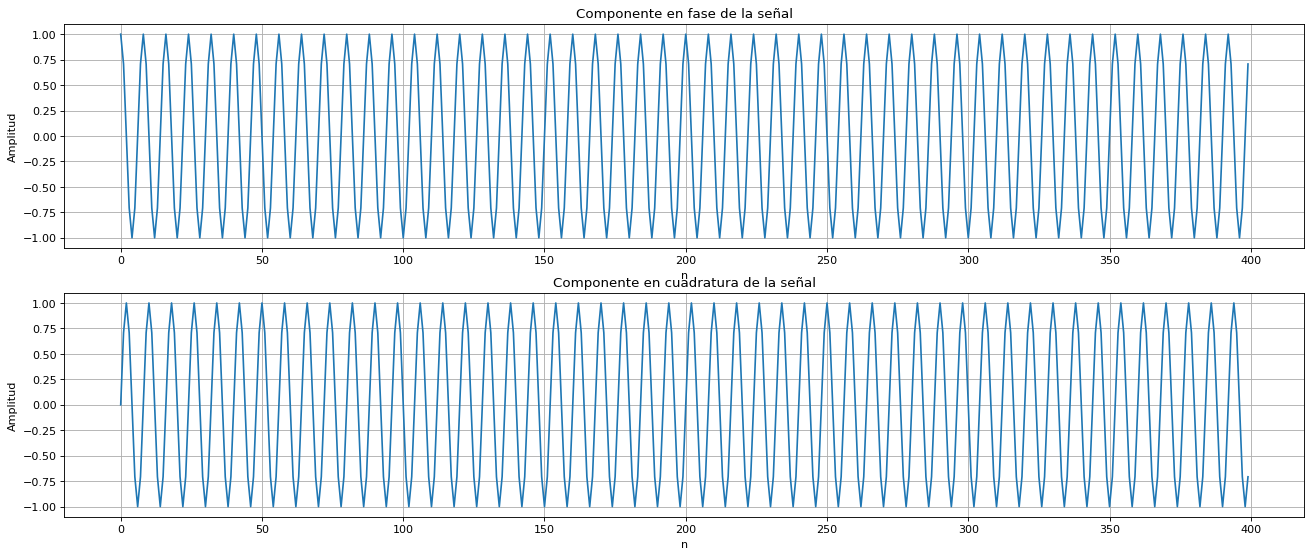

In [41]:
plotSignal(txSignalExp[0:400])

La gráfica del espectro de densidad de potencia puede obtenerse a partir del siguiente código

In [42]:
def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

/tmp/ipykernel_130846/2174936586.py:5: MatplotlibDeprecationWarning: Passing the NFFT parameter of psd() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.psd(signal, len(signal), samplingRate, color='C1')


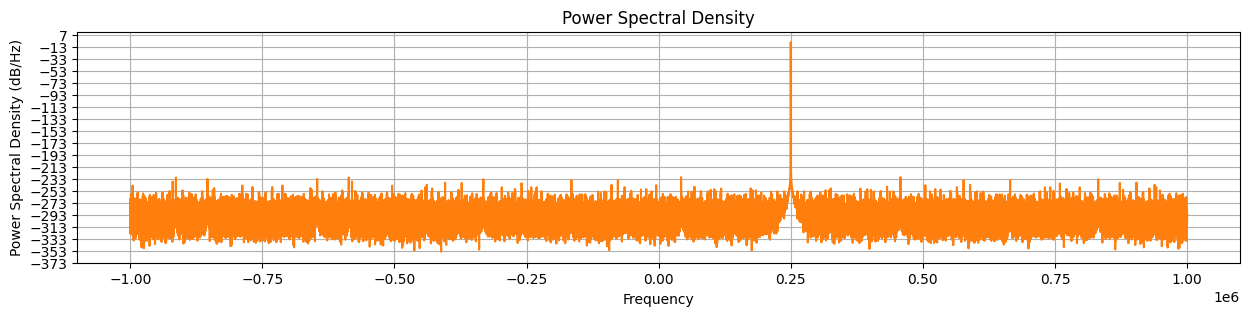

In [43]:
plotSpect(txSignalExp,samplingRate)

La segunda es una señal que implementa una modulación QPSK

In [44]:
#------------------------------- waveform Generator ------------------------------- 
# Create transmit waveform (QPSK modulation with sps samples per symbol)
def qpskGen(numSymbols,sps):
    # numSymbols: Number of complex symbols
    # sps: Number of samples per symbol
    qpskMapper = np.array([1+1j, 1-1j, -1+1j, -1-1j])
    mapIndex   = np.random.randint(0, len(qpskMapper), numSymbols) 
    qpskSymbol = qpskMapper[mapIndex]
    qpskSignal = np.repeat(qpskSymbol, sps)
    return qpskSymbol, qpskSignal;

In [45]:
sps        = 2**4
numSymbols = int(nSamples/sps)
txSymbol, txSignalQpsk = qpskGen(numSymbols,sps)

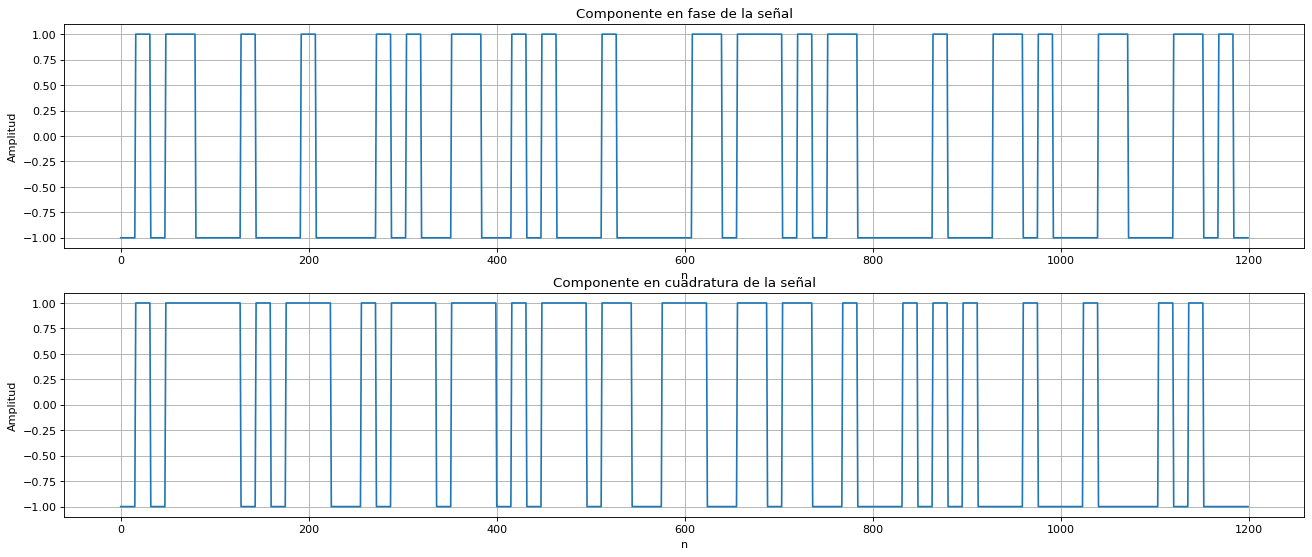

In [46]:
plotSignal(txSignalQpsk[0:1200])

/tmp/ipykernel_130846/2174936586.py:5: MatplotlibDeprecationWarning: Passing the NFFT parameter of psd() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.psd(signal, len(signal), samplingRate, color='C1')


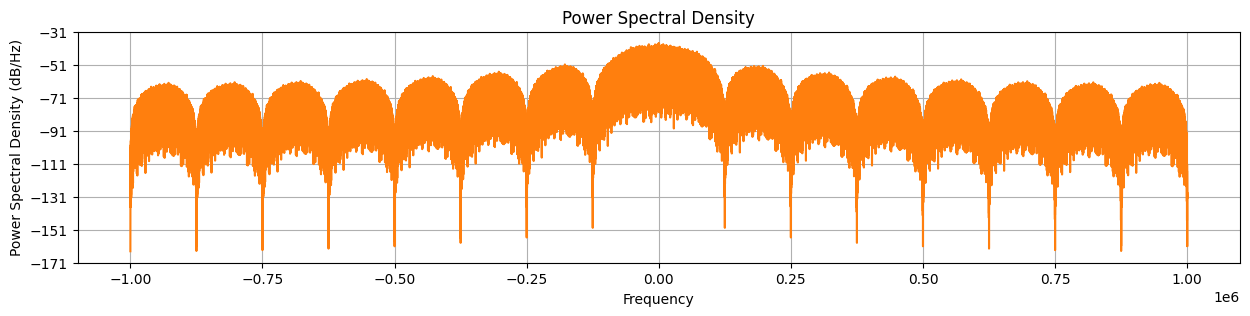

In [47]:
plotSpect(txSignalQpsk,samplingRate)

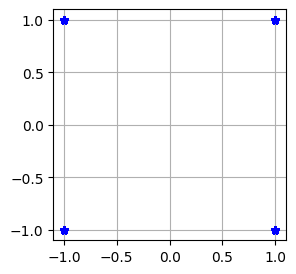

In [48]:
plt.figure(figsize=(3,3))
plt.plot(np.real(txSymbol[0:numSymbols]),np.imag(txSymbol[0:numSymbols]),'b*')
plt.grid()
plt.show()

## Parámetros de configuración del SDR

In [49]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = Uri
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter
SamplingRate     = samplingRate  # Sample rate RX and TX paths[Samples/Sec]

TxLOFreq         = 938e6         # Carrier frequency of TX path [Hz]
TxAtten          = -60           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
RxBufferSize     = nSamples      # Depend on the length of the transmit signal. Maximum tx buffer size 2**24[samples]
tx_cyclic_buffer = True

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual"      # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20       # Rx Buffer size. Maximun value 2**28 [Samples]

## Lazo de retorno
El primer parámetro de configuración es el lazo de retorno o Loopback. Como se puede observar en la Figura 2, el chip posee un bloque que permite enviar, de forma directa, la señal digital ingresada en los pines de entrada del transmisor hacia los pines de salida del receptor, sin pasar por ninguna de las etapas del transceptor. Esta configuración se consigue seteando el parámetro "sdr.loopback" con el valor 1. En caso de setearlo con el valor 2, el transceptor funcionará como un repetidor, emitiendo por el transmisor la señal recibida por el receptor. Para desactivar cualquier tipo de lazo de retorno se debe cargar el parámetro con el valor 0. 
- **Rango de valores del lazo de retorno:**
 - **0: Desactivado**
 - **1: Realimentación de la señal digital**
 - **2: Realimentación de la señal de RF**

In [50]:
sdr.loopback = Loopback

## Frecuencia de muestreo
El segundo parámetro de configuración a describir es el "sdr.sample_rate". Este parámetro define la frecuencia a la cual el AD9363 va a estar procesando las muestras digitales correspondientes a las componentes en fase y en cuadratura de la parte transmisora y receptora. Para el caso en que los datos digitales sean generados o entregados un Host remoto de forma continua, como por ejemplo una computadora, la máxima frecuencia de muestreo a configurar va a depender del límite de velocidad soportado por el tipo de conexión al Host remoto.

- **Rango de la frec. de muestreo: 521 KSPS a 61.44 MSPS**

In [51]:
sdr.sample_rate = samplingRate  # Sample rate RX and TX paths[Samples/Sec]

## Ancho de banda en RF
En la parte receptora, la señal que sale de los mezcladores de RF es filtrada para eliminar los efectos de alias y para reducir la interferencia y el ruido fuera de banda. Un amplificador de transimpedancia (TIA) y un filtro analógico se configuran y funcionan de forma conjunta para mantener el ancho de banda analógico deseado, cuyo rango va desde los 200 kHz hasta los 20 MHz. El TIA actúa como un filtro de un polo y el filtro analógico es un filtro Butterworth de tercer orden programable.
- **Rango del ancho de banda en RF del transmisor y del receptor: 200Khz a 20 Mhz**

In [52]:
sdr.tx_rf_bandwidth = int(TxRfBw)  # Bandwidth of front-end analog filter of TX path [Hz]
sdr.rx_rf_bandwidth = int(RxRfBw)  # Bandwidth of front-end analog filter of RX path [Hz] 

## Ganancia del Hardware
La ganancia total de la etapa receptora es configurada por dos parámetros "sdr.gain_control_mode_chan0" y "sdr.rx_hardwaregain_chan0". El primero de ellos define si la configuración va a ser manual o automática. En caso de elegir la configuración manual, "sdr.gain_control_mode_chan0" es utilizado para definir la ganancia. Este valor está asociado con una tabla de ganancias ubicada dentro del AD9363. Por lo tanto, cuando el valor de ganancia total cambia, varias etapas en la cadena de recepción se actualizan según esta tabla interna. En caso de requerir configuraciones personalizadas, es posible modificar la tabla de ganancias. Para el caso de ganancia automática se cuenta con opciones del tipo respuesta rápida (fast attack) o respuesta lenta (Low attack). Para estas últimas configuraciones, el control de la ganancia es realizado por una máquina de estado dentro del AD9363 que va adaptando su valor según la intensidad de la señal de recepción (RSSI). Si la transmisión recibida es muy corta o cambia rápidamente de amplitud, el modo Fast Attack será la mejor opción. En cambio, cuando la amplitud de la señal recibida cambie lentamente es preferible el uso del modo Slow Attack.
- **Modos del control de ganancia: "manual", "slow_attack", "fast_attack".**
- **Rango del valor de ganancia en modo manual: 0 a 90 dB.** 

In [53]:
sdr.tx_hardwaregain_chan0   = TxAtten # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
sdr.rx_hardwaregain_chan0   = RxHardwareGain   # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
sdr.gain_control_mode_chan0 = GainControlModes # Receive path AGC Options: slow_attack, fast_attack, manual

## Frecuencia de portadora
El transceptor cuenta con un par de mezcladores en cuadratura en la parte transmisora/receptora, los cuales permiten procesar/obtener las componentes en fase y cuadratura y realizar su traslado en frecuencia. Desde el punto de vista del receptor, la arquitectura implementada para llevar la señal de RF a banda base es la llamada conversión directa (o Zero Forcing). En este tipo de arquitectura no se hace uso de etapas de frecuencia intermedia. El rango de operación de los mezcladores va desde los 325 Mhz hasta los 3.8 Ghz, pero se pueden hacer [modificaciones](https://wiki.analog.com/university/tools/pluto/users/customizing) en el software para ampliar este rango.

- **Rango de los osciladores de RF en el transmisor y en el receptor: 325 Mhz a 3.800 Mhz**


In [54]:
sdr.tx_lo = int(TxLOFreq)# Carrier frequency of TX path [Hz]
sdr.rx_lo = int(RxLOFreq) # Carrier frequency of RX path [Hz]

## Buffers

In [55]:
sdr.rx_buffer_size   = RxBufferSize
sdr.tx_cyclic_buffer = tx_cyclic_buffer
#sdr._ctrl.context.set_timeout(0) # <- disable timeout if you want to use large buffer size

## Transmitiendo y Recibiendo
Las lineas de código que permiten transmitir y recibir las señales por el SDR son:

In [56]:
#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignalExp*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

In [57]:
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

Gráfica temporal de la señal recibida

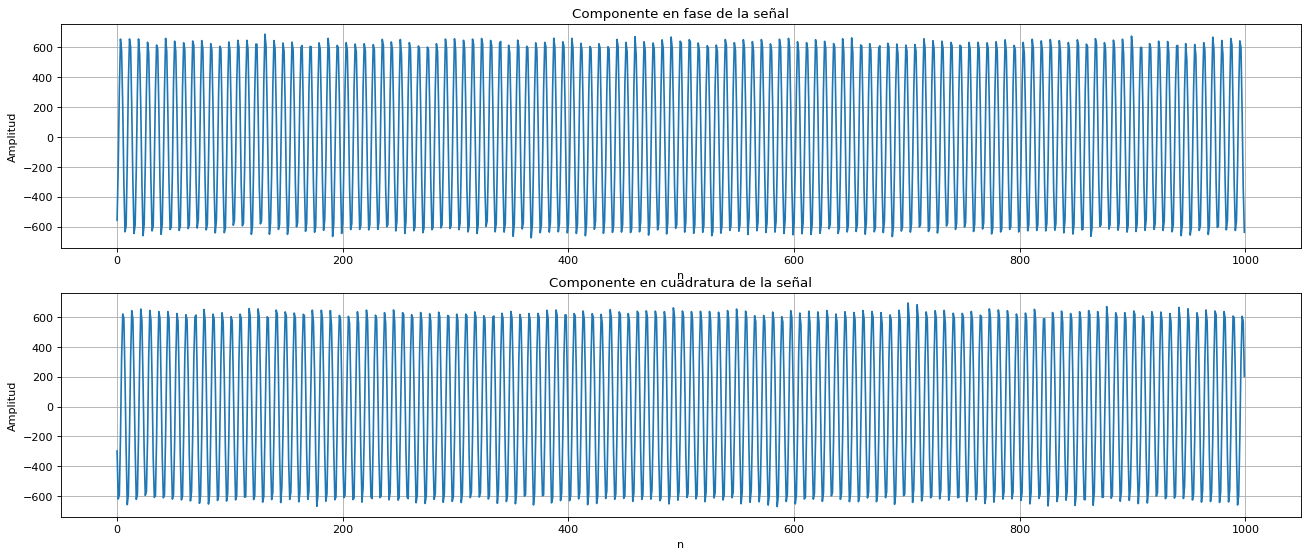

In [58]:
plotSignal(rxSignal[0:1000])

Gráfica de la densidad espectral de potencia de la señal recibida

/tmp/ipykernel_130846/2174936586.py:5: MatplotlibDeprecationWarning: Passing the NFFT parameter of psd() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.psd(signal, len(signal), samplingRate, color='C1')


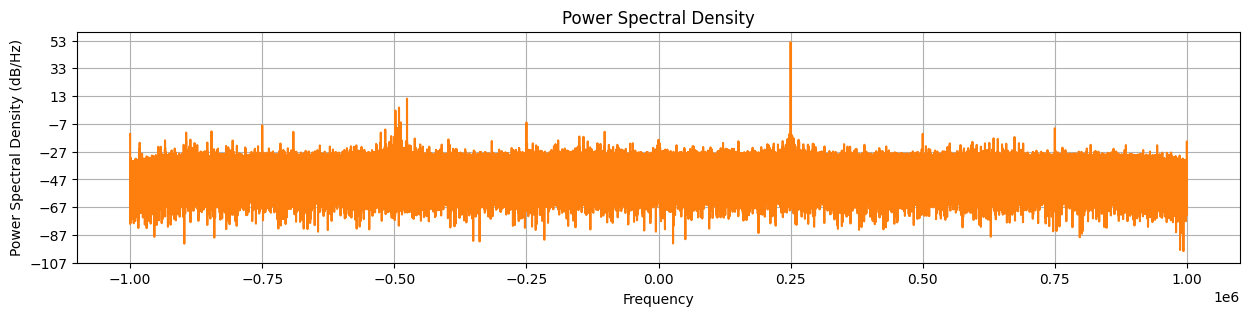

In [59]:
plotSpect(rxSignal,samplingRate)

In [60]:
 #plt.figure(figsize=(3,3))
 #plt.plot(np.real(rxSignal[0:num_symbols]),np.imag(rxSignal[0:num_symbols]),'b*')
 #plt.grid()
 #plt.show()

## Finalizando la experiencia
Dado que no es posible apagar la etapa transmisora del SDR, es recomendable antes de finalizar la experiencia, dejar configurado el transmisor con la máxima atenuación posible, asegurarse que las frecuencias de transmisión y recepción no coinciden y cargar al Buffer transmisor con ceros. Esto permitirá minimizar cualquier posible interferencia por parte del SDR.

In [61]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))


In [62]:
# Destroy radio object
del(sdr)

[![CC BY 4.0][cc-by-shield]][cc-by]

This work is licensed under a
[Creative Commons Attribution 4.0 International License][cc-by].

[![CC BY 4.0][cc-by-image]][cc-by]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-image]: https://i.creativecommons.org/l/by/4.0/88x31.png
[cc-by-shield]: https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg

![logo_neon_erasmus](https://raw.githubusercontent.com/neon-iot/communication_labs/main/detection_theory/notebooks/images/BannerSupportErasmus_.png)

